In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import Data / Drop Data / Dependent Var

In [129]:

# gm = pd.read_csv('database_gmal1801.csv',na_values='None')
# sa = pd.read_csv('autodrive20171_database.csv',na_values='None')
dataset = pd.read_csv('autodrive20171_database.csv', na_values='None')


In [130]:
dataset.dropna (axis=1, how='all', inplace=True)
dataset.replace ('None', 0, regex=True, inplace=True)

dataset.drop (columns=['Unnamed: 0', 'assettypenumber', 'primaryloanservicername'], inplace=True)

In [131]:
dataset.shape

(2038881, 59)

In [132]:
dataset= dataset.drop(dataset[dataset.currentdelinquencystatus>=120].currentdelinquencystatus)

In [133]:
default_asset = dataset[dataset.assetnumber.isin(dataset[dataset.loc[:, 'zerobalancecode']==4].assetnumber)].assetnumber
dataset['Ever Defaulted']= dataset['assetnumber'].isin(default_asset)

In [134]:
dataset['Ever Defaulted'].value_counts()/len(dataset['Ever Defaulted'])*100

False    69.147289
True     30.852711
Name: Ever Defaulted, dtype: float64

In [135]:
dataset['Ever Defaulted'].sum()/len(dataset['Ever Defaulted']) *100

30.85271066794827

In [136]:
# how many people deliquent in this pool
dataset['delinquency']=dataset['currentdelinquencystatus'].apply(lambda x: 0 if x < 32 else 1)
dataset['delinquency'].value_counts()/len(dataset['delinquency'])

0    0.755068
1    0.244932
Name: delinquency, dtype: float64

In [137]:
# Given the unique individuals, how many of those defaulted ? 
len(dataset[dataset.loc[:, 'zerobalancecode']==4]['assetnumber'].value_counts())/len(dataset.assetnumber.value_counts())

0.2762289796120839

## Data Cleaning

In [138]:
deep_south = ["AL", "GA", "LA", "MS", "SC", "NC"]
dataset["Deep South"] = dataset['obligorgeographiclocation'].isin(deep_south)
dataset["Deep South"].value_counts()

False    1559518
True      478559
Name: Deep South, dtype: int64

In [139]:
west = ["WA", "OR", "CA", "ID", "NV", "UT", "MT", "WY", "CO"]
mid_west = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "MI", "IN", "OH"]
northeast = ["NY", "VT", "ME", "PA", "NH", "MA", "RI", "CT", "NJ", "DE", "MD", "DC"]
south = ["AR", "TN", "KY", "WV", "VA", "FL", "MD","AZ", "NM", "TX", "OK"]
deep_south = ["AL", "GA", "LA", "MS", "SC", "NC"]

In [140]:
dataset["West"] = dataset['obligorgeographiclocation'].isin(west)
dataset["MidWest"] = dataset['obligorgeographiclocation'].isin(mid_west)
dataset["Northeast"] = dataset['obligorgeographiclocation'].isin(northeast)
dataset["South"] = dataset['obligorgeographiclocation'].isin(south)
dataset["Deep South"] = dataset['obligorgeographiclocation'].isin(deep_south)
# dataset["Deep South"].value_counts()

In [ ]:
# Clean somoe of the data categories 

dataset['obligoremploymentverificationcode'] = pd.Categorical(dataset['obligoremploymentverificationcode']).rename_categories({1: 'Not Stated Not Verified', 2:'Stated Not Verified', 3: 'Stated and Verified'})

dataset['obligorincomeverificationlevelcode'] = pd.Categorical(dataset['obligorincomeverificationlevelcode']).rename_categories({2: 'Stated Not Verified', 3:'Stated and Verified'})


dataset['vehicletypecode'] = pd.Categorical(dataset['vehicletypecode']).rename_categories({1: 'Car', 2:'Truck', 3: 'SUV'})

dataset['zerobalancecode'] = pd.Categorical(dataset['zerobalancecode']).rename_categories({1: 'Prepaid or Matured', 3: 'Repurchased or Replaced', 4: 'Charged-off'})

dataset['vehiclenewusedcode'] = pd.Categorical(dataset['vehiclenewusedcode']).rename_categories({1: 'New', 2:'Used'})

In [146]:
np.mean(dataset[dataset['obligorincomeverificationlevelcode']==3].obligorcreditscore)

538.994341468405

In [148]:
np.mean(dataset[dataset['obligorincomeverificationlevelcode']==2].obligorcreditscore)

568.3394100898211

### Feature Selection

In [99]:
dataset= dataset.drop_duplicates(subset="assetnumber")
dataset['Ever Defaulted'].sum()/len(dataset['Ever Defaulted'])


0.011729639318951837

In [100]:
dataset.shape

(46634, 71)

In [101]:
dataset.columns

Index(['assetnumber', 'reportingperiodbeginningdate', 'reportingperiodendingdate', 'originatorname', 'originationdate', 'originalloanamount', 'originalloanterm', 'loanmaturitydate', 'originalinterestratepercentage', 'interestcalculationtypecode', 'originalinterestratetypecode', 'originalinterestonlytermnumber', 'originalfirstpaymentdate', 'underwritingindicator', 'graceperiodnumber', 'paymenttypecode', 'subvented', 'vehiclemanufacturername', 'vehiclemodelname', 'vehiclenewusedcode', 'vehiclemodelyear', 'vehicletypecode', 'vehiclevalueamount', 'vehiclevaluesourcecode', 'obligorcreditscoretype', 'obligorcreditscore', 'obligorincomeverificationlevelcode', 'obligoremploymentverificationcode', 'coobligorindicator', 'paymenttoincomepercentage', 'obligorgeographiclocation', 'assetaddedindicator', 'remainingtermtomaturitynumber', 'reportingperiodmodificationindicator', 'servicingadvancemethodcode', 'reportingperiodbeginningloanbalanceamount', 'nextreportingperiodpaymentamountdue',
       'repo

In [102]:
var_factors = [
               'subvented', 'vehiclenewusedcode', 'vehicletypecode',
               'obligoremploymentverificationcode',
               'obligorincomeverificationlevelcode']
var_quants = ['originalloanamount', 'originalloanterm', 'originalinterestratepercentage',
              'obligorcreditscore',
              'paymenttoincomepercentage', 'remainingtermtomaturitynumber', 'servicingfeepercentage', 'totalactualamountpaid',
              ]
var = var_factors + var_quants
var_geo = ['West', 'MidWest', 'Northeast', 'South', 'Deep South']
var = var_factors + var_quants + var_geo


In [103]:
# var_num = [ 'originalinterestratepercentage', 
#            'obligorcreditscore', 'paymenttoincomepercentage', 'Deep South','originalloanamount'
#            ,'originalloanterm', 'vehiclemodelyear','vehiclevalueamount']

# # var_factors = ['obligorincomeverificationlevelcode','obligoremploymentverificationcode']

# var = var_factors + var_num

In [104]:
dataset.corr()['Ever Defaulted'][dataset.corr()['Ever Defaulted']>=0.50]

Ever Defaulted    1.0
Name: Ever Defaulted, dtype: float64

In [105]:
dataset.corr()['delinquency'][dataset.corr()['delinquency']>=0.50]

totalactualamountpaid             0.615660
actualprincipalcollectedamount    0.616230
currentdelinquencystatus          0.820163
delinquency                       1.000000
Name: delinquency, dtype: float64

In [106]:
cor = dataset[var]
cor.corr()[cor.corr()>=0.5]

,subvented,originalloanamount,originalloanterm,originalinterestratepercentage,obligorcreditscore,paymenttoincomepercentage,remainingtermtomaturitynumber,servicingfeepercentage,totalactualamountpaid,West,MidWest,Northeast,South,Deep South
subvented,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
originalloanamount,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
originalloanterm,NaN,NaN,1.000000,NaN,NaN,NaN,0.644492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
originalinterestratepercentage,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obligorcreditscore,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paymenttoincomepercentage,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remainingtermtomaturitynumber,NaN,NaN,0.644492,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
servicingfeepercentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
totalactualamountpaid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
West,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [107]:
# ind = dataset.assetnumber.value_counts().index
# for i in ind[14500:15000]:
#     print(dataset[dataset.assetnumber ==i].obligorcreditscore)

In [108]:
# var_num = ['originalloanamount', 'originalinterestratepercentage', 
#            'originalloanterm', 'paymenttoincomepercentage', 'Deep South'] # 'remainingtermtomaturitynumber', 'vehiclemodelyear', 'graceperiodnumber', 'obligorcreditscore'

# var_factors = ['vehiclenewusedcode']

In [109]:
dataset.drop(dataset[~dataset['zerobalancecode'].isna()].index, inplace = True) 


In [110]:
# drop zero balance code 
dataset.drop(['zerobalancecode'], axis =1, inplace = True)

In [111]:
# Creat dependent variables
var_drop = list(set(dataset.columns.values)-set(var))
dataset = pd.get_dummies(dataset, columns=var_factors)

In [112]:
X = dataset.drop(columns=var_drop)
y = dataset[['Ever Defaulted']]

In [114]:
y['Ever Defaulted'].sum()/len(y)*100

0.9782536849758742

In [74]:
X.shape, y.shape

((68164, 26), (68164, 1))

In [75]:
X_na = X.loc[:, X.isna().any()]

In [76]:
y_na = y.loc[:, y.isna().any()]

In [77]:
y_na.columns

Index([], dtype='object')

In [78]:
X_na.columns

Index(['originalloanterm', 'originalinterestratepercentage', 'obligorcreditscore', 'paymenttoincomepercentage', 'remainingtermtomaturitynumber', 'totalactualamountpaid'], dtype='object')

In [79]:
from sklearn.impute import SimpleImputer
import numpy as np
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_impute = imp_mean.fit_transform(X_na)

In [80]:
X_impute = pd.DataFrame(X_impute, columns=list(X_na.columns.values))

In [81]:
X.drop(columns=X_na.columns.to_list(), inplace=True)

In [82]:
X.head()

,originalloanamount,servicingfeepercentage,Deep South,West,MidWest,Northeast,South,subvented_0.0,subvented_1.0,subvented_2.0,vehiclenewusedcode_New,vehiclenewusedcode_Used,vehicletypecode_Car,vehicletypecode_Truck,vehicletypecode_SUV,obligoremploymentverificationcode_Not Stated Not Verified,obligoremploymentverificationcode_Stated Not Verified,obligoremploymentverificationcode_Stated and Verified,obligorincomeverificationlevelcode_Stated Not Verified,obligorincomeverificationlevelcode_Stated and Verified
1,16699.00,0.04,False,False,False,False,True,1,0,0,0,1,0,1,0,0,1,0,0,1
2,18099.08,0.04,True,False,False,False,False,1,0,0,0,1,0,0,1,0,0,1,0,1
4,15785.00,0.04,True,False,False,False,False,1,0,0,0,1,1,0,0,0,0,1,0,1
7,21608.35,0.04,False,False,False,False,True,1,0,0,0,1,1,0,0,0,0,1,0,1
9,27800.00,0.04,False,False,True,False,False,1,0,0,1,0,1,0,0,0,1,0,0,1


In [83]:
for col in list(X_na.columns):
    X[col] = X_impute.loc[:, col].values


In [84]:
X.shape

(68164, 26)

## ML Step 1: TestTrain Split - Stratified

In [194]:
# ! pip install xgboost
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [195]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)


In [196]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape ,'\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape)

X_shapes:
 X_train: X_validation:
 (54355, 26) 

Y_shapes:
 Y_train: Y_validation:
 (54355, 1)


##  ML Step 2: Cross Validation

In [197]:
##Spot-Checking Algorithms

models = []

models.append(('LR', LogisticRegression(n_jobs=8)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('XGB', XGBClassifier(n_jobs=8)))
models.append(('RF', RandomForestClassifier(n_jobs=8)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5,metric='euclidean')))



In [198]:
#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.664362 (0.011326)
CART: 0.570434 (0.008294)
XGB: 0.751094 (0.006615)
RF: 0.731401 (0.008722)
NB: 0.572316 (0.007488)
KNN: 0.621927 (0.015714)


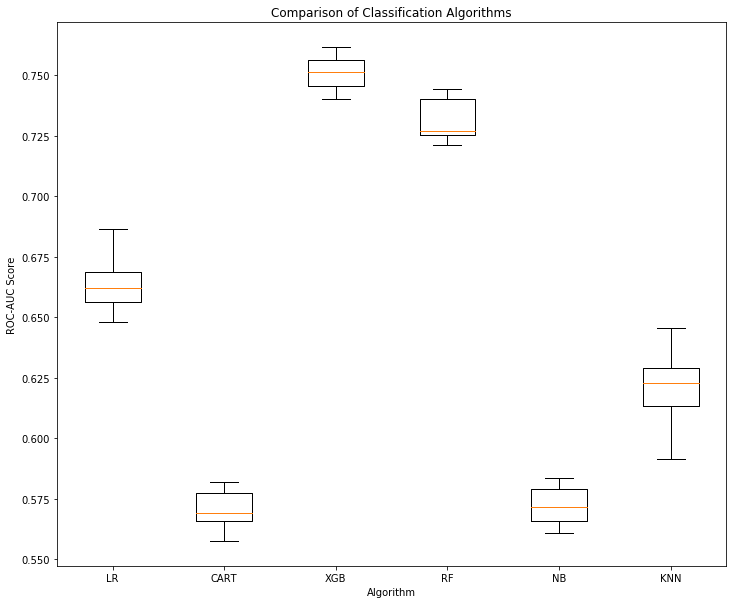

In [199]:
#Compare Algorithms
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Logistics Regression

In [200]:
import statsmodels.api as sm
logreg = LogisticRegression()
logreg.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [201]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


In [202]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      1.00      0.91     11250
        True       0.00      0.00      0.00      2339

    accuracy                           0.83     13589
   macro avg       0.41      0.50      0.45     13589
weighted avg       0.69      0.83      0.75     13589



## Naive Bayes

In [203]:
nb= GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [204]:
y_pred = nb.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(nb.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [205]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.88      0.86     11250
        True       0.21      0.15      0.18      2339

    accuracy                           0.76     13589
   macro avg       0.52      0.52      0.52     13589
weighted avg       0.73      0.76      0.74     13589



# KNN

In [206]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [207]:
y_pred = knn.predict(X_test)
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.80


In [208]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.94      0.89     11250
        True       0.32      0.14      0.20      2339

    accuracy                           0.80     13589
   macro avg       0.58      0.54      0.54     13589
weighted avg       0.75      0.80      0.77     13589



## XGboost Model  

In [209]:
xgb = XGBClassifier(n_jobs=8)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [210]:
y_test = y_test.values

In [211]:
y_test = y_test.reshape([len(y_test)])

In [212]:
preds = xgb.predict(X_test)
print(pd.crosstab(y_test, preds, rownames=['Actual '], colnames=['Predicted ']))

Predicted   False  True 
Actual                  
False       10908    342
True         2020    319


In [213]:
import joblib
import pickle
# # Save to file in the current working directory
joblib_file = "XGBoost_gm.pkl"
joblib.dump(xgb, joblib_file)



['XGBoost_gm.pkl']

In [214]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

       False       0.84      0.97      0.90     11250
        True       0.48      0.14      0.21      2339

    accuracy                           0.83     13589
   macro avg       0.66      0.55      0.56     13589
weighted avg       0.78      0.83      0.78     13589



In [215]:
from sklearn.metrics import roc_curve

No handles with labels found to put in legend.


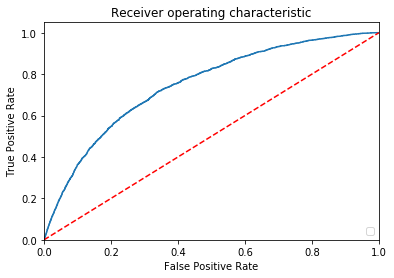

In [216]:
random_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
random_fpr, random_tpr, random_thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(random_fpr, random_tpr, random_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [217]:
importance_df_xgb = pd.DataFrame(list(zip(X, xgb.feature_importances_)), columns=['Features', 'Importances'])
importance_df_xgb = importance_df_xgb.sort_values(by=['Importances'], ascending=False)
plot_importance = importance_df_xgb.head(10)

In [218]:
importance_df_xgb.head(10)

,Features,Importances
25,totalactualamountpaid,0.138283
24,remainingtermtomaturitynumber,0.094058
20,originalloanterm,0.081033
1,servicingfeepercentage,0.079557
21,originalinterestratepercentage,0.052390
3,West,0.046582
13,vehicletypecode_Truck,0.042669
9,subvented_2.0,0.038080
0,originalloanamount,0.035833
23,paymenttoincomepercentage,0.035257


In [1]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.bar(x=importance_df_xgb['Features'], height=importance_df_xgb['Importances'])
plt.xticks(rotation=90)
plt.show()

NameError: name 'plt' is not defined

## Decision Tree 

In [220]:
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# check for the sklearn version, it has to be 0.21
import sklearn
print(sklearn.__version__)

0.22.1


In [221]:
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
preds = cart.predict(X_test)
print(pd.crosstab(y_test, preds, rownames=['Actual '], colnames=['Predicted ']))

Predicted   False  True 
Actual                  
False        9437   1813
True         1667    672


In [222]:
# plt.figure(figsize=(25,10))

# a = plot_tree(cart, 
#               feature_names=X_train.columns, 
#               class_names=['True','False'], 
#               filled=True, 
#               rounded=True, max_depth=1,
#               fontsize=14)

In [223]:
# # Save to file in the current working directory
joblib_file = "CART_gm.pkl"
joblib.dump(cart, joblib_file)

['CART_gm.pkl']

In [224]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.85      0.84      0.84     11250
        True       0.27      0.29      0.28      2339

    accuracy                           0.74     13589
   macro avg       0.56      0.56      0.56     13589
weighted avg       0.75      0.74      0.75     13589



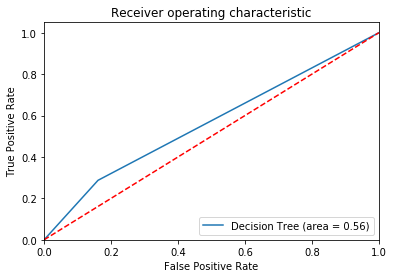

In [225]:
random_roc_auc = roc_auc_score(y_test, cart.predict(X_test))
random_fpr, random_tpr, random_thresholds = roc_curve(y_test, cart.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(random_fpr, random_tpr, label='Decision Tree (area = %0.2f)' % random_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [226]:
importance_df_cart = pd.DataFrame(list(zip(X, cart.feature_importances_)), columns=['Features', 'Importances'])
importance_df_cart = importance_df_cart.sort_values(by=['Importances'], ascending=False)
plot_importance = importance_df_cart.head(5)

In [227]:
importance_df_cart.head(5)['Importances'].sum()

0.770709262323496

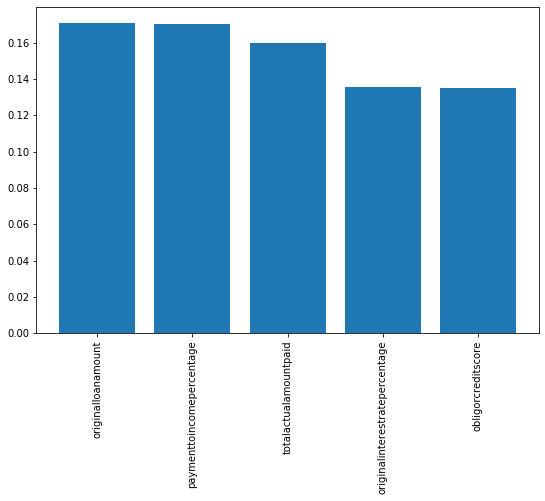

In [228]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.bar(x=importance_df_cart['Features'].head(5), height=importance_df_cart['Importances'].head(5))
plt.xticks(rotation=90)
plt.show()

## Random Forest 

In [229]:
RF = RandomForestClassifier(n_jobs=8)
RF.fit(X_train, y_train)

preds = RF.predict(X_test)
print(pd.crosstab(y_test, preds, rownames=['Actual '], colnames=['Predicted ']))

Predicted   False  True 
Actual                  
False       10984    266
True         2082    257


In [230]:
# # Save to file in the current working directory
joblib_file = "RandomForest_gm.pkl"
joblib.dump(RF, joblib_file)

['RandomForest_gm.pkl']

In [231]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90     11250
        True       0.49      0.11      0.18      2339

    accuracy                           0.83     13589
   macro avg       0.67      0.54      0.54     13589
weighted avg       0.78      0.83      0.78     13589



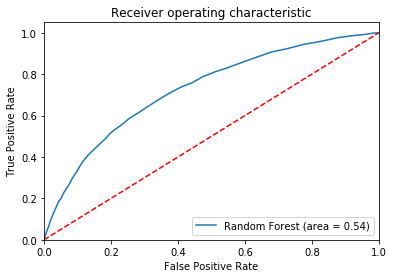

In [232]:
random_roc_auc = roc_auc_score(y_test, RF.predict(X_test))
random_fpr, random_tpr, random_thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(random_fpr, random_tpr, label='Random Forest (area = %0.2f)' % random_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [233]:
importance_df_rf = pd.DataFrame(list(zip(X, RF.feature_importances_)), columns=['Features', 'Importances'])
importance_df_rf = importance_df_rf.sort_values(by=['Importances'], ascending=False)
plot_importance = importance_df_rf.head(10)

In [234]:
importance_df_rf.head(5)

,Features,Importances
25,totalactualamountpaid,0.165844
23,paymenttoincomepercentage,0.156658
0,originalloanamount,0.156032
21,originalinterestratepercentage,0.146285
22,obligorcreditscore,0.136787


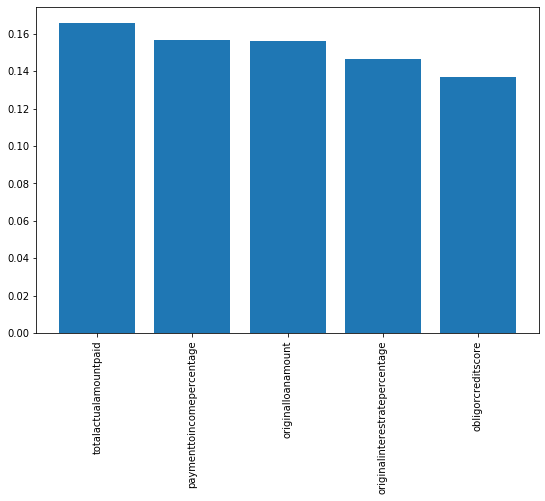

In [235]:

fig, ax = plt.subplots(figsize=(9, 6))

importance_df_rf = importance_df_rf.head(5)
plt.bar(x=importance_df_rf['Features'], height=importance_df_rf['Importances'])

plt.xticks(rotation=90)
plt.show()